In [1]:
import nltk
import random
from nltk.corpus import movie_reviews as mr
from sklearn.feature_extraction.text import CountVectorizer

Miramos como es el fichero:

In [2]:
print(len(mr.fileids()) )#hay 2000 ficheros (1000 exemples positius i 1000 negatius)
print(mr.words('pos/cv000_29590.txt'))
print(mr.categories())
print(mr.fileids('pos')) #lista todos los ficheros positivos
print((list(mr.words('pos/cv000_29590.txt')), 'pos') )

2000
['films', 'adapted', 'from', 'comic', 'books', 'have', ...]
['neg', 'pos']
['pos/cv000_29590.txt', 'pos/cv001_18431.txt', 'pos/cv002_15918.txt', 'pos/cv003_11664.txt', 'pos/cv004_11636.txt', 'pos/cv005_29443.txt', 'pos/cv006_15448.txt', 'pos/cv007_4968.txt', 'pos/cv008_29435.txt', 'pos/cv009_29592.txt', 'pos/cv010_29198.txt', 'pos/cv011_12166.txt', 'pos/cv012_29576.txt', 'pos/cv013_10159.txt', 'pos/cv014_13924.txt', 'pos/cv015_29439.txt', 'pos/cv016_4659.txt', 'pos/cv017_22464.txt', 'pos/cv018_20137.txt', 'pos/cv019_14482.txt', 'pos/cv020_8825.txt', 'pos/cv021_15838.txt', 'pos/cv022_12864.txt', 'pos/cv023_12672.txt', 'pos/cv024_6778.txt', 'pos/cv025_3108.txt', 'pos/cv026_29325.txt', 'pos/cv027_25219.txt', 'pos/cv028_26746.txt', 'pos/cv029_18643.txt', 'pos/cv030_21593.txt', 'pos/cv031_18452.txt', 'pos/cv032_22550.txt', 'pos/cv033_24444.txt', 'pos/cv034_29647.txt', 'pos/cv035_3954.txt', 'pos/cv036_16831.txt', 'pos/cv037_18510.txt', 'pos/cv038_9749.txt', 'pos/cv039_6170.txt', 'pos/cv

# Particion Train y Test:

In [3]:
doc_pos = [mr.words(f) for f in mr.fileids('pos')]
doc_neg = [mr.words(f) for f in mr.fileids('neg')]

In [4]:
random.shuffle(doc_pos)
random.shuffle(doc_neg)

In [5]:
train_pos = doc_pos[:int((len(doc_pos)*0.7))] #70% para el train
test_pos = doc_pos[int((len(doc_pos)*0.7)):] #30% final para el test

train_neg = doc_neg[:int((len(doc_neg)*0.7))]
test_neg = doc_neg[int((len(doc_neg)*0.7)):]

In [10]:
train = train_pos + train_neg
test = test_pos + test_neg

In [11]:
print(len(train_pos), len(train_neg))
print(len(test_pos), len(test_neg))

700 700
300 300


In [12]:
train_labels = [1]*700 + [0]*700
print(len(train_labels))
test_labels = [1]*300 + [0]*300

1400


# Preprocesamiento

In [8]:
import re

def preproces(text):
    text_clean = []
    # Expresión regular para eliminar todo lo que no sea una letra o un espacio
    regex = r"[^a-zA-Z\s]"
    
    # Diccionario de reemplazo
    replacements = {
        "t": "not",
        's': 'is', #aunque tambien puede ser posesivo
        "didn": "did",
        "haven": "have",
        "hasn": "has",
        "hadn": "had",
        "shouldn": "should",
        "wouldn": "would",
        "couldn": "could",
        "mustn": "must",
        'doesn': 'does',
        'isn' : 'is',
        'aren' : 'are',
        'll': 'will',
        've' : 'have', 
        'd' : 'would',
        'm': 'am'
    }
    
    for w in text:
        # Eliminar caracteres no deseados y números
        limpio = re.sub(regex, "", w)
        # Convertir a minúsculas
        limpio = limpio.lower()
        # Eliminar espacios en blanco al principio y al final
        limpio = limpio.strip()
        
        # Reemplazar si está en el diccionario
        if limpio in replacements:
            limpio = replacements[limpio]
        # Filtrar tokens vacíos
        if limpio != "":
            text_clean.append(limpio)
    
    return text_clean

In [13]:
clean_train = [preproces(words) for words in train]
print(clean_train[0])
clean_test = [preproces(words)for words in test]

['capsule', 'the', 'best', 'place', 'to', 'start', 'if', 'you', 're', 'a', 'jackie', 'chan', 'newcomer', 'roars', 'along', 'never', 'stops', 'for', 'breath', 'and', 'frequently', 'hilarious', 'to', 'talk', 'about', 'jackie', 'chan', 'as', 'a', 'stuntman', 'is', 'to', 'miss', 'a', 'million', 'things', 'jackie', 'is', 'not', 'only', 'one', 'of', 'the', 'most', 'accomplished', 'and', 'fearsomely', 'unafraid', 'physical', 'adepts', 'on', 'the', 'screen', 'today', 'but', 'also', 'a', 'very', 'funny', 'guy', 'he', 'reminds', 'me', 'of', 'the', 'way', 'arnold', 'schwartzenegger', 'used', 'to', 'make', 'me', 'laugh', 'he', 'is', 'funny', 'just', 'standing', 'there', 'copping', 'a', 'look', 'supercop', 'has', 'jackie', 'making', 'us', 'laugh', 'scream', 'duck', 'root', 'and', 'gasp', 'for', 'breath', 'often', 'all', 'in', 'the', 'same', 'scene', 'it', 'is', 'actually', 'the', 'third', 'in', 'a', 'loosely', 'related', 'series', 'of', 'movies', 'each', 'with', 'jackie', 'playing', 'kevin', 'chan'

# Lematización

In [14]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/taya/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

Poner tags y no incluir stop Words ya que no aportaran información relevante para el Sentiment Analisys:

In [15]:

def tagger(clean_train):
    train_tagged = []
    tags = set()
    stop_tags = {'DT', 'IN', 'CC', 'PRP', 'PRP$', 'WP', 'WP$', 'RP', 'TO', 'CD', 'EX', 'WDT'}
    for l in clean_train:
        aux = []
        con_tag = nltk.pos_tag(l)
        for w, tag in con_tag:
            if tag not in stop_tags:
                aux.append((w, tag))
                tags.add(tag)
        train_tagged.append(aux)
    return train_tagged, tags

train_tagged, tags = tagger(clean_train)
test_tagged, _ = tagger(clean_test)

In [16]:
print(tags) #todos los tags unicos que aparecen en el train

{'NN', 'VB', 'RBR', 'FW', 'RB', 'POS', 'SYM', 'WRB', 'VBN', 'NNS', 'VBZ', 'VBD', 'NNP', 'VBG', 'NNPS', 'MD', 'JJ', 'RBS', 'JJR', 'VBP', 'PDT', '$', 'UH', 'JJS'}


In [15]:
#ejemplo del resultado
print(train_tagged[0])
print(train[0]) 

[('director', 'NN'), ('brett', 'NN'), ('ratner', 'NN'), ('stars', 'NNS'), ('jackie', 'VBP'), ('chan', 'NN'), ('chris', 'NN'), ('tucker', 'NN'), ('breathed', 'VBD'), ('new', 'JJ'), ('life', 'NN'), ('buddy', 'JJ'), ('action', 'NN'), ('film', 'NN'), ('genre', 'NN'), ('cross', 'NN'), ('cultural', 'JJ'), ('rush', 'NN'), ('hour', 'NN'), ('tune', 'NN'), ('don', 'VBP'), ('not', 'RB'), ('mess', 'JJ'), ('success', 'NN'), ('team', 'NN'), ('is', 'VBZ'), ('back', 'RB'), ('again', 'RB'), ('better', 'RBR'), ('rush', 'JJ'), ('hour', 'NN'), ('combo', 'NN'), ('terrific', 'JJ'), ('physical', 'JJ'), ('talents', 'NNS'), ('chan', 'NN'), ('non', 'JJ'), ('stop', 'NN'), ('motor', 'NN'), ('mouth', 'NN'), ('tucker', 'NN'), ('made', 'VBN'), ('ethnically', 'RB'), ('unusual', 'JJ'), ('duet', 'NN'), ('rush', 'JJ'), ('hour', 'NN'), ('played', 'VBD'), ('well', 'RB'), ('audiences', 'NNS'), ('world', 'NN'), ('formula', 'NN'), ('worked', 'VBD'), ('so', 'RB'), ('well', 'RB'), ('fact', 'NN'), ('sequel', 'NN'), ('was', 'VBD

In [16]:
#ver otros ejemplos de palabras con un cierto tag
palabras = []
for l in train_tagged:
    for palabra, etiqueta in l:
            if etiqueta == '$':
                palabras.append(palabra)
print(palabras)

['lambs', 'ten']


El tag '$' es un error del tagger pero vemos que no supondrá ningún problema.

Además, al observar el tag "FW" (palabras que se etiquetan como extranjeras) vemos que podríamos eliminar errores, palabras en otros idiomas, nombres propios, pero también palabras normales.

Como posteriormnte se va a hacer filtrado de frequencias esperamos que se eliminarán las palabras no deseadas y quedarán las que sí que tienen sentido.

Acontinuación, se lematizan solo estas categorias, reconocidas por SentiWordNet:

* **Sustantivos ('n'):**    'NN', 'NNS', 'NNP', 'NNPS'
* **Verbos ('v'):**     'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
* **Adjetivos ('a'):**  'JJ', 'JJR', 'JJS'
* **Adverbios ('r'):**  'RB', 'RBR', 'RBS'

In [19]:
wnl = nltk.stem.WordNetLemmatizer()

def lemmatize(p):
  d = {'NN': 'n', 'NNS': 'n', 'NNP' : 'n', 'NNPS':'n', #sustantivos
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a',  #adjetivos 
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 'MD':'v', #verbos
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}  #adverbios
  if p[1] in d:
    return wnl.lemmatize(p[0], pos=d[p[1]])
  return p[0]

In [18]:
def lemmatize_tagged(train_tagged):    
    train_lemat = []
    for l in train_tagged:
        aux = []
        for i in l:
            aux.append(lemmatize(i))
        train_lemat.append(aux)
    return train_lemat

train_lemat = lemmatize_tagged(train_tagged)
test_lemat = lemmatize_tagged(test_tagged)

## Vectroización BoW

Aunque la vectorización se ejecutará junto con el entrenamiento de los modelos, primero se realiza una vectorización inicial para explorar la distribución de frecuencias de las palabras y ajustar los parámetros del vectorizador. En este apartado se incluyen los siguientes pasos:

1. **Vectorización inicial**: Se utiliza `CountVectorizer` para transformar los documentos en una matriz de frecuencias de términos.
2. **Distribución de frecuencias**: Se calcula y visualiza la distribución de frecuencias de las palabras en el conjunto de entrenamiento.
3. **Eliminación de frecuencias bajas**: Se filtran las palabras con frecuencias bajas para reducir el ruido y mejorar el rendimiento de los modelos.
4. **Vectorización final**: Se aplica la vectorización con los parámetros ajustados para preparar los datos para el entrenamiento de los modelos supervisados.

In [20]:
vectorizer = CountVectorizer()
train_aplanado = [' '.join(sublista) for sublista in train_lemat]
X_train = vectorizer.fit_transform(train_aplanado)

In [20]:
X_train.shape

(1400, 27477)

Eliminacion de frequencias bajas

In [21]:
# Sumamos las frecuencias de cada palabra en todos los documentos
word_frequencies = X_train.sum(axis=0).A1
# Obtenemos el vocabulario mapeado a índices
words = vectorizer.get_feature_names_out()
# Convertimos en un diccionario {palabra: frecuencia}
freq_dict = dict(zip(words, word_frequencies))
# Ordenamos por frecuencia ascendente
sorted_freq = sorted(freq_dict.items(), key=lambda x: x[1])
print(sorted_freq[:10])  # Muestra las 10 palabras menos frecuentes


[('aaaaaaaahhhh', np.int64(1)), ('aahs', np.int64(1)), ('aaliyah', np.int64(1)), ('aamir', np.int64(1)), ('aatish', np.int64(1)), ('ab', np.int64(1)), ('aback', np.int64(1)), ('abberation', np.int64(1)), ('abbreviated', np.int64(1)), ('abby', np.int64(1))]


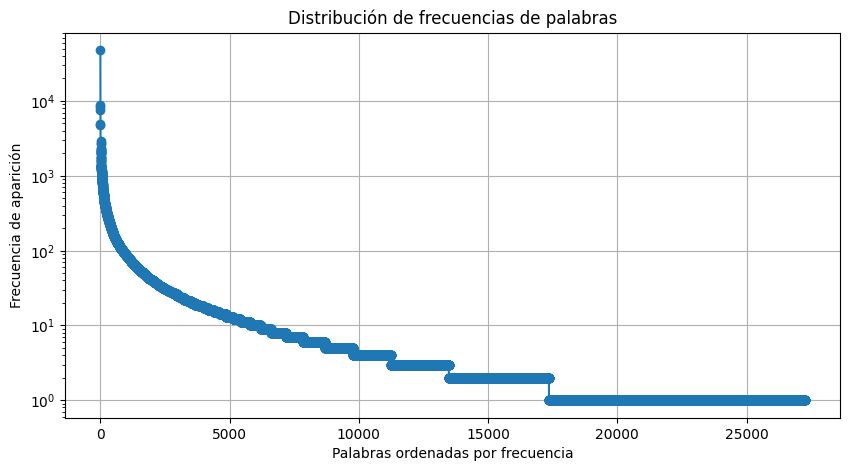

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ordenamos las frecuencias en orden descendente para mejor interpretacion de la grafica
sorted_freq_values = np.array(sorted(word_frequencies, reverse=True))

# Creamos la gráfica
plt.figure(figsize=(10,5))
plt.plot(sorted_freq_values, marker="o", linestyle="-")

plt.xlabel("Palabras ordenadas por frecuencia")
plt.ylabel("Frecuencia de aparición")
plt.title("Distribución de frecuencias de palabras")
plt.yscale("log") 
plt.grid()

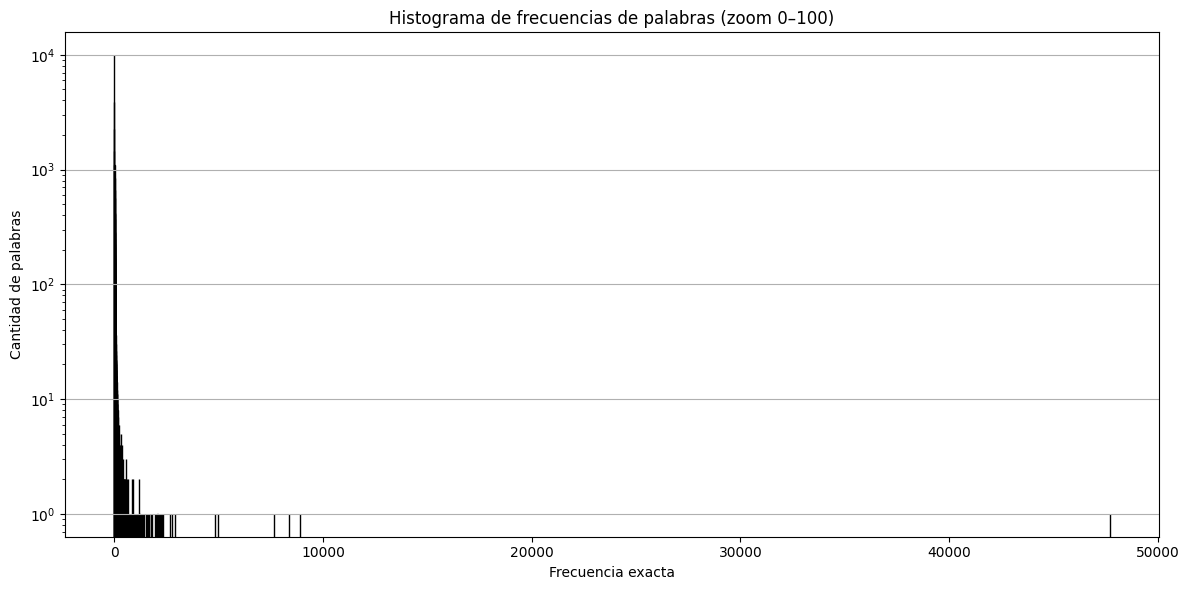

In [24]:
# Histograma detallado con límite en eje X
max_freq = int(max(word_frequencies))

plt.figure(figsize=(12,6))
plt.hist(word_frequencies, bins=np.arange(1, max_freq + 1), edgecolor='black', log=True)

plt.xlabel("Frecuencia exacta")
plt.ylabel("Cantidad de palabras")
plt.title("Histograma de frecuencias de palabras (zoom 0–100)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


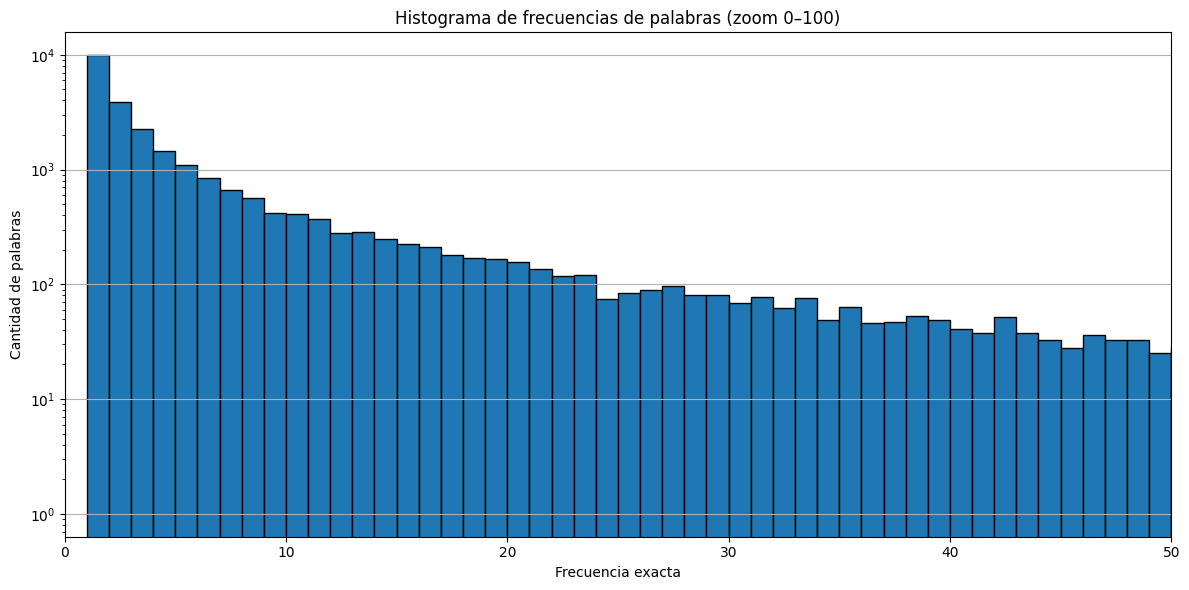

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(word_frequencies, bins=np.arange(1, max_freq + 1), edgecolor='black', log=True)

plt.xlabel("Frecuencia exacta")
plt.ylabel("Cantidad de palabras")
plt.title("Histograma de frecuencias de palabras (zoom 0–100)")
plt.grid(axis='y')
# 🔍 Zoom en el eje X
plt.xlim(0, 50)
plt.tight_layout()
plt.show()

In [26]:
min_freq = 3  # Umbral mínimo (si se pone mas agrande se eliminaran mas de la mitad de las observaciones)
vectorizer = CountVectorizer(min_df=min_freq)
X_filtered = vectorizer.fit_transform(train_aplanado)

Distribución de frequencias filtrada:

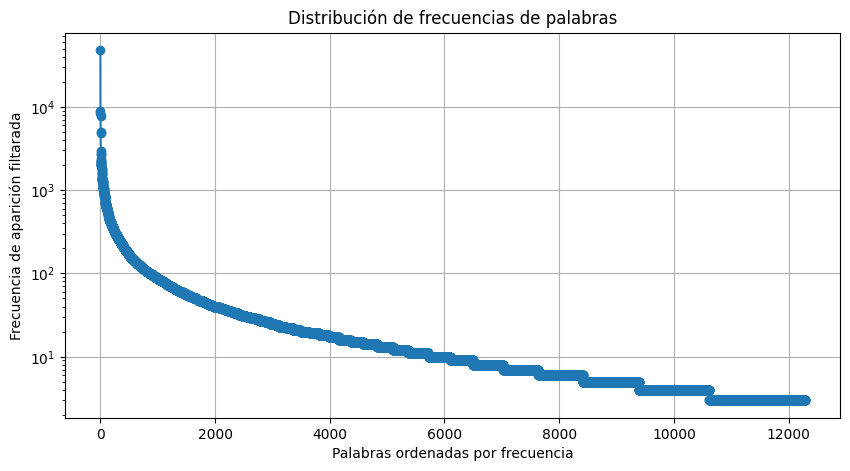

In [27]:
word_frequencies = X_filtered.sum(axis=0).A1
sorted_freq_values = np.array(sorted(word_frequencies, reverse=True))

# Creamos la gráfica
plt.figure(figsize=(10,5))
plt.plot(sorted_freq_values, marker="o", linestyle="-")
plt.xlabel("Palabras ordenadas por frecuencia")
plt.ylabel("Frecuencia de aparición filtarada")
plt.title("Distribución de frecuencias de palabras")
plt.yscale("log") 
plt.grid()

In [28]:
X_filtered.shape #train final

(1400, 12285)

# Modelos supervisados. Parte 1:

Una vez que ya tengamos los datos preprocesados de manera que faciliten a los modelos a classificar los documentos, empezaremos a construir los modelos supervisados. 

Para esta práctica hemos querido comparar tres modelos supervisados significativamente diferentes entre ellos: KNN, Random Forest y SVM (Support Vector Machine). Para cada uno de los modelos se contemplará el mismo procedimiento de entrenamiento. 

Primero de todo, se usará la función **GridSearchCV** (internamente también entrena el modelo con diferentes particions de **train** y **validation**) para encontrar los mejores parámetros que se ajusten a los datos del train, posteriormente se aplicará la función cross_validate para obtener las medidas de valoración del modelo (las mejores medidas después de entrenarlos con diferentes *folds*). 

In [29]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd

# datos
X = train_aplanado
y = train_labels

# Métricas que quieres evaluar
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

# Resultados globales
resultados = {}

# ----------- MODELO 1: KNN -----------
pipe_knn = Pipeline([
    ('vectorizer', CountVectorizer(min_df=3)),
    ('clf', KNeighborsClassifier())
])

param_knn = {
    'clf__n_neighbors': [3, 5, 7]
}

grid_knn = GridSearchCV(pipe_knn, param_grid=param_knn, cv=5, scoring='accuracy')
grid_knn.fit(X, y)

mejor_knn = grid_knn.best_estimator_

# ----------- MODELO 2: Random Forest -----------
pipe_rf = Pipeline([
    ('vectorizer', CountVectorizer(min_df=3)),
    ('clf', RandomForestClassifier(random_state=42))
])

param_rf = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10, 100]
}

grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf, cv=5, scoring='accuracy')
grid_rf.fit(X, y)
mejor_rf = grid_rf.best_estimator_

# ----------- MODELO 3: SVM -----------
pipe_svm = Pipeline([
    ('vectorizer', CountVectorizer(min_df=3)),
    ('clf', SVC())
])

param_svm = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf']
}

grid_svm = GridSearchCV(pipe_svm, param_grid=param_svm, cv=5, scoring='accuracy')
grid_svm.fit(X, y)
mejor_svm = grid_svm.best_estimator_

In [30]:
# Diccionario de modelos a comparar
modelos = {
    "KNN": mejor_knn,
    "RandomForest": mejor_rf,
    "SVM": mejor_svm
}

# Guardamos resultados
resultados = {}

# mejor_knn, mejor_rf, mejor_svm son Pipelines que contienen el mejor modelo y el vectorizador. 
for nombre, modelo in modelos.items():
    cv_result = cross_validate(modelo, X, y, cv=5, scoring=scoring)

    resumen = {métrica: round(cv_result[f'test_{métrica}'].mean(), 4) for métrica in scoring}
    resultados[nombre] = resumen


# Mostrar como DataFrame ordenado
df_resultados = pd.DataFrame(resultados).T
print("🔍 Los mejores resultados de cada modelo:")
print(df_resultados)


🔍 Los mejores resultados de cada modelo:
              accuracy  f1_macro  precision_macro  recall_macro
KNN             0.6050    0.5789           0.6403        0.6050
RandomForest    0.8100    0.8099           0.8108        0.8100
SVM             0.8179    0.8178           0.8184        0.8179


## Aplicación al *test*

Después de obtener cada modelo con sus mejores parámetros a través de **GridSearch**, predecimos con estos modelos para los datos del test y obtenemos a partir de allí el accuracy y la matriz de confusión. 

In [31]:
# Con los mejores modelos entrenados, predecimos sobre el conjunto de test
X_test = [' '.join(sublista) for sublista in test_lemat]
y_test = test_labels

# Predicciones
y_pred_knn = mejor_knn.predict(X_test)
y_pred_rf = mejor_rf.predict(X_test)
y_pred_svm = mejor_svm.predict(X_test)

# Accuracy
acc_knn = mejor_knn.score(X_test, y_test)
acc_rf = mejor_rf.score(X_test, y_test)
acc_svm = mejor_svm.score(X_test, y_test)

# Matriz de Confusión
from sklearn.metrics import confusion_matrix

cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_svm = confusion_matrix(y_test, y_pred_svm)


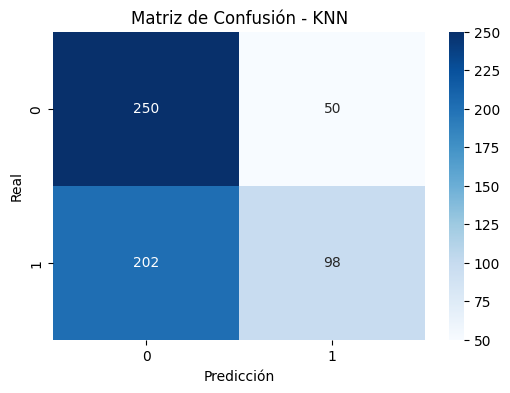

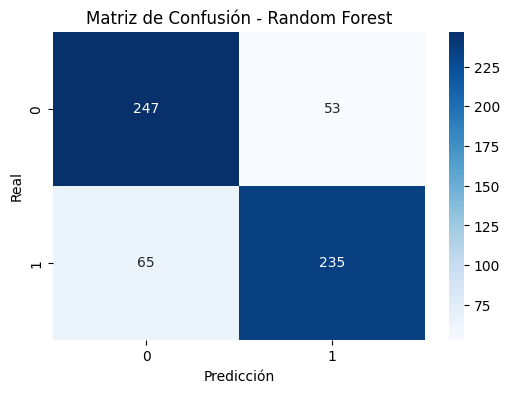

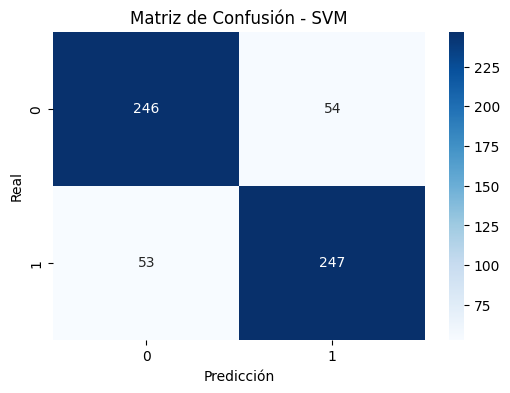

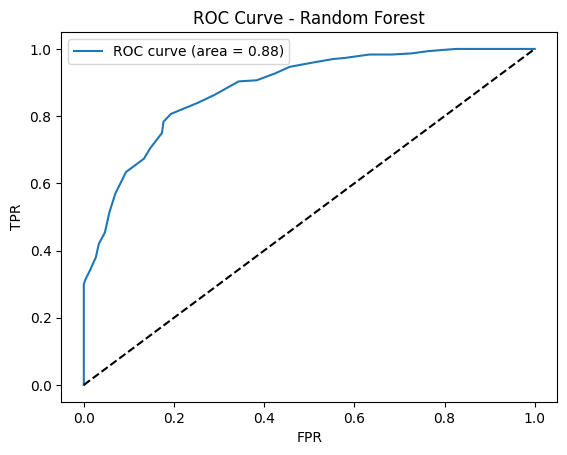

KNN:
               precision    recall  f1-score   support

           0       0.55      0.83      0.66       300
           1       0.66      0.33      0.44       300

    accuracy                           0.58       600
   macro avg       0.61      0.58      0.55       600
weighted avg       0.61      0.58      0.55       600

Random Forest:
               precision    recall  f1-score   support

           0       0.79      0.82      0.81       300
           1       0.82      0.78      0.80       300

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600

SVM:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       300
           1       0.82      0.82      0.82       300

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82   

In [ ]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

model_names = ['KNN', 'Random Forest', 'SVM']
cms = [cm_knn, cm_rf, cm_svm]
preds = [y_pred_knn, y_pred_rf, y_pred_svm]

for i, cm in enumerate(cms):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_names[i]}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Solo si es binario:
fpr, tpr, _ = roc_curve(y_test, mejor_rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()

print("KNN:\n", classification_report(y_test, y_pred_knn))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("SVM:\n", classification_report(y_test, y_pred_svm))

# Crear un diccionario con los accuracies
ranking_dict = {
    'Modelo': ['KNN', 'Random Forest', 'SVM'],
    'Accuracy': [acc_knn, acc_rf, acc_svm]
}

# Crear DataFrame y ordenarlo de mayor a menor
ranking_df = pd.DataFrame(ranking_dict)
ranking_df = ranking_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Mostrar el ranking
print("📊 Ranking de modelos según Accuracy:")
print(ranking_df)


# Modelos no supervisados. Parte 2:

En el anterior ==> pos_tags (sintaxis)
Este ==> significados

In [33]:
from textserver import TextServer 
ts = TextServer('jajajajaj', 'Text_2025', 'senses') 
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from collections import Counter

### Preprocesamiento:

In [34]:
def filtrar_y_limpiar(tagged_docs, etiquetas_validas, min_freq=2):
    # 1. Filtrar por etiquetas válidas
    filtrados_por_pos = [
        [w for w, tag in doc if tag in etiquetas_validas]
        for doc in tagged_docs
    ]

    # 2. Calcular frecuencias globales
    word_freq = Counter()
    for doc in filtrados_por_pos:
        word_freq.update(doc)

    # 3. Eliminar palabras con frecuencia < min_freq
    filtered_words = {word for word, freq in word_freq.items() if freq < min_freq}
    docs_filtrados = [
        [word for word in doc if word not in filtered_words]
        for doc in filtrados_por_pos
    ]

    return docs_filtrados

### Obtención de los synsets:

Hemos observado que TextServer es incapaz de detectar algunos synsets pero el algoritmo de Lesk sí, por ejemplo:

In [ ]:
result = ts.senses('lively')[0][0]
print(result)
print(lesk(train_lemat[8], 'lively'))

Por lo tanto, si el algoritmo de UKB es incapaz de encontrar el synset se va a intentar encontrarlo mediante Lesk:

In [36]:
# Algunos ejemplos son capaces de obtener el synset del lesk, pero no del Freeling.
def get_synsets(w, contexto):
    try:
        result = ts.senses(w)[0][0]
        categ = result[4][-1]
        id = int(result[4][0:8])
        synset1 = wn.synset_from_pos_and_offset(categ, id)
        return synset1
    except:
        return lesk(contexto, w) 

In [ ]:
#Metodo que incluye la busqueda de sinonimos

def get_synsets2(w, contexto):
    # 1. Intenta obtener el synset directamente con ts.senses
    try:
        result = ts.senses(w)[0][0]
        categ = result[4][-1]
        id = int(result[4][0:8])
        synset = wn.synset_from_pos_and_offset(categ, id)
        return synset
    except:
        pass  # Si falla, pasa al siguiente método
    
    # 2. Intenta con el algoritmo Lesk
    synset_lesk = lesk(contexto, w)
    if synset_lesk is not None:
        return synset_lesk
    
    # 3. Si todo falla, busca sinónimos y prueba con ellos
    synonyms = set()  
    
    # Obtenemos todos los lemas (sinónimos) de WordNet para la palabra
    for syn in wn.synsets(w):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ")  # Limpia guiones bajos
            if synonym.lower() != w:  # Evita la palabra original
                synonyms.add(synonym)
    
    # Probamos cada sinónimo con ts.senses y Lesk
    for synonym in synonyms:
        # Intenta con ts.senses
        try:
            result = ts.senses(synonym)[0][0]
            categ = result[4][-1]
            id = int(result[4][0:8])
            synset = wn.synset_from_pos_and_offset(categ, id)
            return synset
        except:
            pass
        
        # Intenta con Lesk si ts.senses falla
        synset_lesk = lesk(contexto, synonym)
        if synset_lesk is not None:
            return synset_lesk
    
    # Si nada funciona, retorna None 
    return None

#### ¿ Qué ocurre si el synset no está en SentiWordnet?

**1)Propagación basada en relaciones semánticas**

Utilizar la jerarquía de WordNet para propagar puntuaciones desde synsets relacionados.
- Buscar sinónimos del synset ausente
- Si se encuentra en SentiWordNet, propagar sus valores al synset ausente

PROBLEMA: El valor estará a una distancia semántica diferente que el valor real

**2)Asignación de valores neutros**

Asignar un valor neutral (0) a todos los synsets no encontrados.
Este enfoque asume que las palabras ausentes no contribuyen al sentimiento del texto. SentiWordNet se enfoca en palabras con carga emocional clara, y por tanto, las palabras ausentes probablemente sean neutras en términos de sentimiento.

- "La ausencia de ciertos términos en léxicos de sentimiento como SentiWordNet puede interpretarse como evidencia de su naturaleza semánticamente neutra en contextos evaluativos" (Baccianella et al., 2010).

### El método:

Clasificación de polaridad siguiendo la siguiente fórmula:

**score(s) = poss − neg**

Donde *poss* representa el score de positividad y *neg* el score de negatividad.
Cuando la fórmula se aplica a todo un texto, el resultado será un único valor numérico que representa la polaridad global del texto:

- Un valor positivo (+) indica que el texto tiene una tendencia general positiva
- Un valor negativo (-) indica que el texto tiene una tendencia general negativa
- Un valor cercano a cero sugiere que el texto es mayormente neutro

In [37]:

def predecir_sentimiento(lista_docs):
    etiquetas_predichas = []

    for doc in lista_docs:
        pos_s = 0
        neg_s = 0

        for w in doc:
            s1 = get_synsets(w, doc)
            if s1 is not None:
                try:
                    senti_synset = swn.senti_synset(s1.name())
                    pos_s += senti_synset.pos_score()
                    neg_s += senti_synset.neg_score()
                except:
                    pass  # si no está en SentiWordNet
        etiquetas_predichas.append(1 if pos_s - neg_s >= 0 else 0)

    return etiquetas_predichas

In [38]:
# Definir etiquetas útiles para sentimiento
POS_RELEVANTES = {'JJ', 'JJR', 'JJS',  # Adjetivos
                  'NN', 'NNS', 'NNP', 'NNPS',  # Sustantivos
                  'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',  # Verbos
                  'RB', 'RBR', 'RBS'}  # Adverbios

SOLO_ADJETIVOS = {'JJ', 'JJR', 'JJS'}

In [ ]:
docs_relevantes = filtrar_y_limpiar(train_tagged, POS_RELEVANTES)
print(sum(len(doc) for doc in docs_relevantes))
preds_relevantes = predecir_sentimiento(docs_relevantes)

551081


In [ ]:
docs_adjetivos = filtrar_y_limpiar(train_tagged, SOLO_ADJETIVOS)
preds_adjetivos = predecir_sentimiento(docs_adjetivos)

In [ ]:

print("🔍 Evaluación con POS relevantes:")
print(classification_report(train_labels, preds_relevantes))

print("\n🔍 Evaluación con solo adjetivos:")
print(classification_report(train_labels, preds_adjetivos))


In [ ]:
from sklearn.linear_model import LogisticRegression

# POS relevantes
POS_TAGS = {
    'adj': {'JJ', 'JJR', 'JJS'},
    'verb': {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'},
    'adv': {'RB', 'RBR', 'RBS'},
    'noun': {'NN', 'NNS', 'NNP', 'NNPS'}
}

def extract_pos_sentiment_features(tagged_docs):
    X = []
    for doc in tagged_docs:
        scores = {'adj': 0, 'verb': 0, 'adv': 0, 'noun': 0}
        tokens = [w for w, _ in doc]

        for w, tag in doc:
            pos_category = None
            for key, tag_set in POS_TAGS.items():
                if tag in tag_set:
                    pos_category = key
                    break
            if pos_category:
                syn = lesk(tokens, w)
                if syn:
                    try:
                        senti = swn.senti_synset(syn.name())
                        scores[pos_category] += senti.pos_score() - senti.neg_score()
                    except:
                        pass
        X.append([scores['adj'], scores['verb'], scores['adv'], scores['noun']])
    return np.array(X)

# Extraemos features
X_features = extract_pos_sentiment_features(train_tagged)
y = train_labels

# Métricas a evaluar
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

# Modelos
modelos = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Resultados
resultados = {}

for nombre, modelo in modelos.items():
    print(f"🧪 Evaluando {nombre}...")
    cv_result = cross_validate(modelo, X_features, y, cv=5, scoring=scoring)
    resumen = {métrica: round(np.mean(cv_result[f'test_{métrica}']), 4) for métrica in scoring}
    resultados[nombre] = resumen

# Mostrar tabla de resultados
df_resultados = pd.DataFrame(resultados).T
print("\n📊 Resultados promedio con cross-validation:")
print(df_resultados)

# ENTRENAR FINAL para mostrar coeficientes / importancias
print("\n🎯 Pesos finales entrenando con todo el dataset:")

lr_model = modelos["LogisticRegression"].fit(X_features, y)
rf_model = modelos["RandomForest"].fit(X_features, y)

# Pesos LR
print("\nCoeficientes (LogisticRegression):")
for i, pos in enumerate(['adj', 'verb', 'adv', 'noun']):
    print(f"{pos}: {lr_model.coef_[0][i]:.4f}")

# Importancias RF
print("\nImportancia por feature (RandomForest):")
for i, pos in enumerate(['adj', 'verb', 'adv', 'noun']):
    print(f"{pos}: {rf_model.feature_importances_[i]:.4f}")


🧪 Evaluando LogisticRegression...
🧪 Evaluando RandomForest...

📊 Resultados promedio con cross-validation:
                    accuracy  f1_macro  precision_macro  recall_macro
LogisticRegression    0.6543    0.6540           0.6547        0.6543
RandomForest          0.6371    0.6361           0.6390        0.6371

🎯 Pesos finales entrenando con todo el dataset:

Coeficientes (LogisticRegression):
adj: 0.1895
verb: 0.1000
adv: 0.1356
noun: 0.0084

Importancia por feature (RandomForest):
adj: 0.3100
verb: 0.2252
adv: 0.2365
noun: 0.2283


In [ ]:
def extract_pos_sentiment_features(tagged_docs):
    X = []
    for doc in tagged_docs:
        scores = {'adj': 0, 'verb': 0, 'adv': 0, 'noun': 0}
        tokens = [w for w, _ in doc]

        for w, tag in doc:
            pos_category = None
            for key, tag_set in POS_TAGS.items():
                if tag in tag_set:
                    pos_category = key
                    break
            if pos_category:
                syn = lesk(tokens, w)
                if syn:
                    try:
                        senti = swn.senti_synset(syn.name())
                        scores[pos_category] += senti.pos_score() - senti.neg_score()
                    except:
                        pass
        X.append([scores['adj'], scores['verb'], scores['adv'], scores['noun']])
    return np.array(X)


def predecir_sentimiento(tagged_docs_nuevos, modelo):
    # Extraer los features POS-sentiment
    X_nuevos = extract_pos_sentiment_features(tagged_docs_nuevos)

    # Predecir usando el modelo entrenado
    etiquetas_predichas = modelo.predict(X_nuevos)

    return etiquetas_predichas

# Nuevos documentos POS-tagged
predicciones = predecir_sentimiento(test_tagged, rf_model)
